In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geocoder


import warnings
warnings.filterwarnings("ignore")

from math import sqrt
from scipy import stats
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.cluster import KMeans

import env
import acquire_zillow
import prepare
import wrangle_clustering



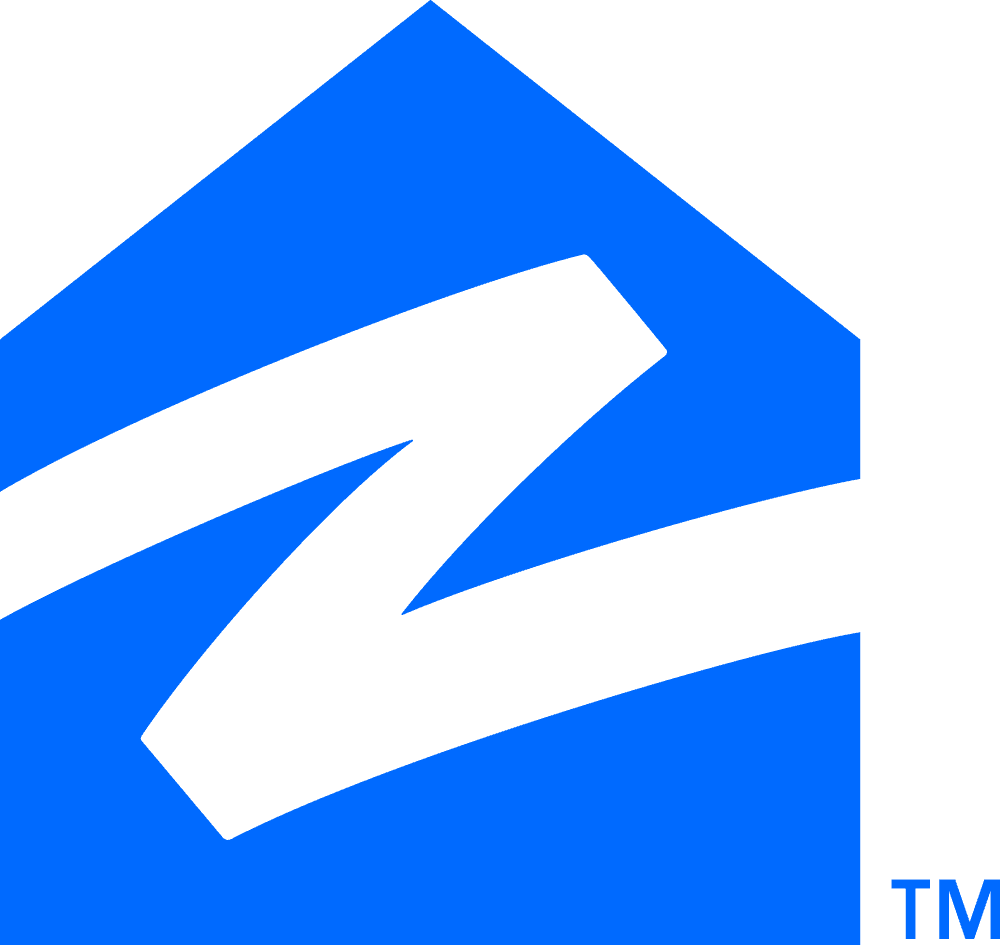

# Predicting from A to Zillow

Lincoln Muriithi 06/20/2022

## About this Project:
### Project Goals
#### - To identify drivers of logerror in the Zestimate in order to improve accuracy of predicting home values
#### - Achieve this using clustering and feature engineering 


----

# Project Description

#### - Decreasing the Zestimate error is important because it will enable us to increase accuracy which will attract more customers and increase our profit margins
#### - Zillow will be able to maintain its competitive advantage 
#### - The model selected will be evaluated by how well the test set performs over the baseline and previous models.


# Data Acquisition 

- #### Acuired the Zillow data from the Sql database 
- #### Saved the data in a csv file
- #### Stored the data in a in a function as a dataframe 
- #### The original data has 52440 rows and 6 columns


---

# Preparation

### Steps taken for a clean dataset
1. #### Addressed missing values by dropping them since they were less than 10% of the initial data 

2. #### In order to simulate an ordinary homebuyer I took care of the outliers by:
     - removing houses over 8000 sqfeet, below 70feet
     - removing houses costing over 1.8 million in tax dollar amount 
     - removing rows with houses over 8 bedrooms and 8 bathrooms 
     
3. #### Converted fips column to categorical and changed the names to county names for readability purposes 
     - Ventura for  "6111"
     - Orange for"6059
     - Los_Angeles for "6037"

4. #### Feature engineering:
     - converted max transaction date to  specific months 
     - converted year built into age of the property
     - added a feature price per bathroom price_bath = df.taxvaluedollarcnt/ df.bathroomcnt
     - engineered a feature price per sqft called price_sqft = df.taxvaluedollarcnt/calculatedfinishedsquarefeet
     - added a feature average price per region called df taxvaluedollarcnt_zone
     
5. #### Dropped many columns after using Kbest to find the best features to predict taxvaluedollarcnt and logerror
        - used a function, more information on the data dictionary

6. #### Created a function that splits the data into train, validate and test dataframes

7. #### Created a function that that scaled the data for modeling purposes

8. #### Started off with 67 columns and 52000 rows and ended up with 17 columns and 49000 rows


In [2]:
# acquiring and preparing data. This function gets data from sql into a CSV file that is clean and prepared for exploration
df = wrangle_clustering.wrangle_zillow()
df.head()


,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,county,longitude,latitude,regionidzip,yearbuilt,taxvaluedollarcnt,max_transactiondate,logerror,propertylandusedesc,month,county_Los_Angeles,county_Orange,county_Ventura
0,14297519,3.5,4.0,3100.0,Orange,-117869207.0,33634931.0,96978.0,1998.0,1023282.0,2017-01-01,0.025595,Single Family Residential,1,0,1,0
1,17052889,1.0,2.0,1465.0,Ventura,-119281531.0,34449266.0,97099.0,1967.0,464000.0,2017-01-01,0.055619,Single Family Residential,1,0,0,1
2,14186244,2.0,3.0,1243.0,Orange,-117823170.0,33886168.0,97078.0,1962.0,564778.0,2017-01-01,0.005383,Single Family Residential,1,0,1,0
3,12177905,3.0,4.0,2376.0,Los_Angeles,-118240722.0,34245180.0,96330.0,1970.0,145143.0,2017-01-01,-0.103410,Single Family Residential,1,1,0,0
4,12095076,3.0,4.0,2962.0,Los_Angeles,-118179824.0,34145202.0,96293.0,1950.0,773303.0,2017-01-01,-0.001011,Single Family Residential,1,1,0,0


In [3]:
#this code takes in a dataframe and and prepares the the new features, adding them to dataframe 
new_features = prepare.engineered_features(df)


---

### Splitting Data
 - I split the data using a function wrangle_clustering.split_data
 - the function returns a train, validate and test dataframe

In [4]:
#this code is a function in the prepare file that takes in a df and returns split data(train validate and test)
train, validate, test = prepare.split_data(new_features)
train.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,longitude,latitude,regionidzip,taxvaluedollarcnt,logerror,month,county_Los_Angeles,county_Orange,county_Ventura,price_sqft,age,price_bath,taxvaluedollarcnt_zone,age_bin,price_region_bins
51848,12523284,2.0,3.0,1515.0,-118131493.0,33787932.0,96247,127532.0,-0.219901,9,1,0,0,84.179538,66.0,63766,395420,60 to 70,350k to 500k
22251,14425080,3.5,4.0,3971.0,-117634477.0,33486309.0,96985,561691.0,0.020527,5,0,1,0,141.448250,20.0,160483,655931,15 to 30,650k to 850k
18204,10956129,1.0,2.0,910.0,-118355657.0,34170194.0,96437,550000.0,-0.023169,4,1,0,0,604.395604,76.0,550000,373306,70 to 120,350k to 500k
52042,11265901,2.0,4.0,2410.0,-118180778.0,34655632.0,97319,336348.0,-0.334645,9,1,0,0,139.563485,31.0,168174,238889,30 to 45,100k to 250k
4133,12487491,1.0,3.0,1066.0,-118109620.0,33842943.0,96213,213231.0,0.043699,1,1,0,0,200.029081,67.0,213231,316056,60 to 70,250k to 350k


---

### Scaling Data
#### the function used is prepare.scaling_minmax. it takes in train, validate and test, copies them and returns scaled versions
#### tried using both the minmax and the standard, however, minmax was more advantageous 
#### here are the columns to scale:
        - calculatedfinishedsquarefeet
        - taxvaluedollarcnt
        - price_sqft
        - price_bath
        - taxvaluedollarcnt_zone
        - logerror


In [5]:
columns_to_scale = ["calculatedfinishedsquarefeet","taxvaluedollarcnt","price_sqft","price_bath","taxvaluedollarcnt_zone","logerror"]
train_scaled, validate_scaled,test_scaled =prepare.scaling_minmax(train, validate, test, columns_to_scale)


---

## Exploration

-  According to the features in the zillow dataset, there were atleast 58 features with plenty of information. However, in the end I chose to stick to 17 features. 
-  The following questions arose after doing some of domain research:

1. #### does the logerrror have a relationship with the number of bathrooms or bedrooms ? 
2. #### does price per bathroom have a relationship with logerror?
3. #### does the zipcode affect the logerror?
4. #### does the age of the house logerror? 
5. #### does price per sqfoot have a relationship with logerror?


### 1. does the logerrror have a relationship with the number of bathrooms or bedrooms ? 


No handles with labels found to put in legend.


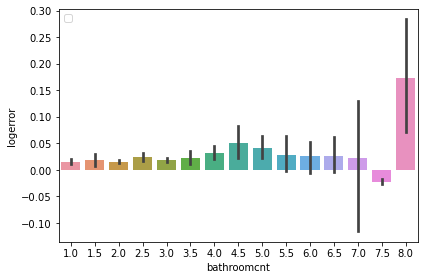

No handles with labels found to put in legend.


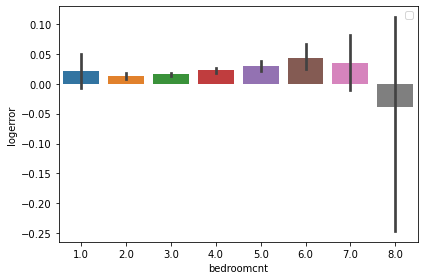

In [6]:
target = train.logerror
columns_to_plot = train[["bathroomcnt","bedroomcnt"]]

# I use a for loop to boxplot my independent variables against our dependent one:
for col in columns_to_plot:
    sns.barplot(x=columns_to_plot[col], y=target, data=columns_to_plot)
    plt.ylabel('logerror')
    plt.xlabel(col)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Takeaways
### 1. does the logerrror have a relationship with the number of bathrooms or bedrooms ? 
#### -  it appears that the logerror is signifficantly higher in the average houses (between 6 and 8 bedrooms
#### -  houses with 7.5 bathrooms have a negative log error while houses with 8 have a signifficantly high logerror
#### -  it is difficult to read the quartiles but the tails show a significant part of the distribution

---


###  2. does price bathroom have a relationship with logerror?


<AxesSubplot:xlabel='logerror', ylabel='price_bath'>

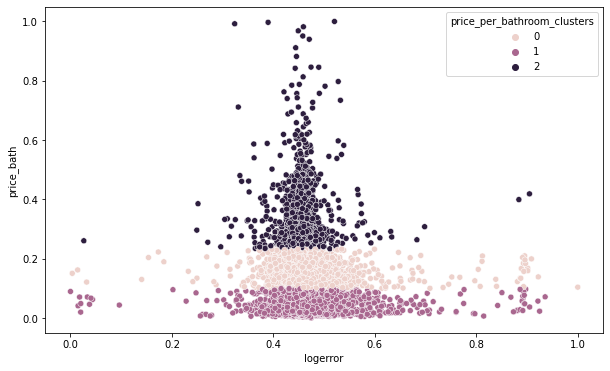

In [7]:
X= train[["price_bath","logerror"]]
# def cluster_features(df, k):
kmeans = KMeans(n_clusters =3, random_state=347)

#group1 = train_scaled[['age','price_bath','taxvaluedollarcnt_zone','taxvaluedollarcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet','price_sqft']]
kmeans.fit(X)
kmeans.predict(X)
train_scaled['price_per_bathroom_clusters'] = kmeans.predict(X)
plt.figure(figsize=(10, 6))
sns.scatterplot(x = 'logerror', y = 'price_bath', data = train_scaled, hue = 'price_per_bathroom_clusters')

# sns.scatterplot(x = 'logerror', y = 'price_bath', data = train_scaled, hue = 'clustered_features')


## Takeaways
###  2. does price bathroom have a relationship with logerror?
#### - it appears that the homes within the lower ranges of price per bathrooms have a signifficantly higher logerror
#### - it seems like the ML from zillow is mis pricing the more average homes

---

### 3. does the average price per zone affect the log error?

<AxesSubplot:xlabel='logerror', ylabel='taxvaluedollarcnt_zone'>

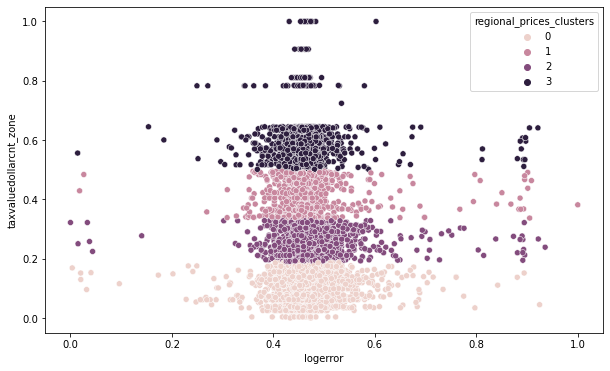

In [8]:
X= train[["taxvaluedollarcnt_zone","logerror"]]
# def cluster_features(df, k):
kmeans = KMeans(n_clusters =4, random_state=347)

#group1 = train_scaled[['age','price_bath','taxvaluedollarcnt_zone','taxvaluedollarcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet','price_sqft']]
kmeans.fit(X)
kmeans.predict(X)
train_scaled['regional_prices_clusters'] = kmeans.predict(X)
plt.figure(figsize=(10, 6))
sns.scatterplot(x = 'logerror', y = 'taxvaluedollarcnt_zone', data = train_scaled, hue = 'regional_prices_clusters')

# sns.scatterplot(x = 'logerror', y = 'taxvaluedollarcnt_zone', data = train_scaled, hue = 'clustered_features')

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

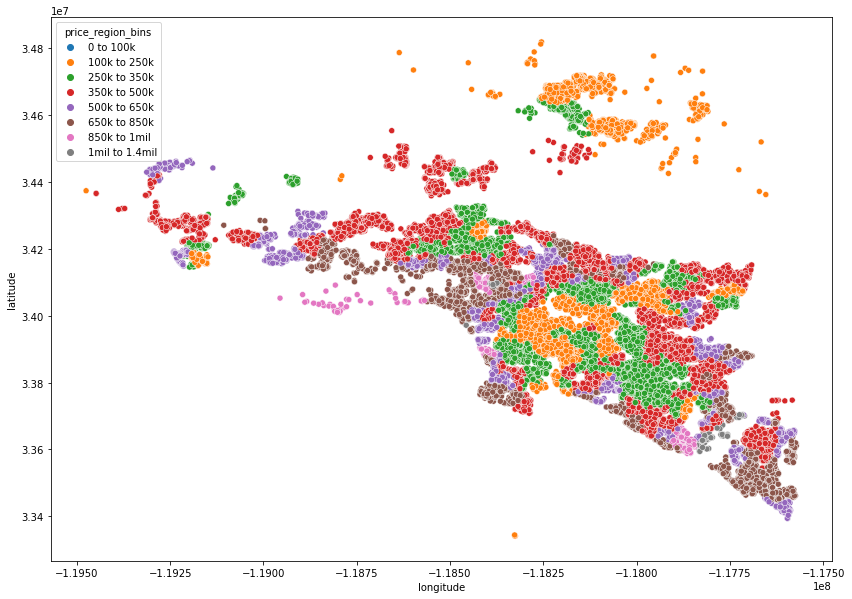

In [9]:
plt.figure(figsize=(14,10))
sns.scatterplot(x='longitude', y='latitude', hue=train.price_region_bins, data=train)


## Takeaways
### 3. does the average price per zone affect the log error?
#### - it appears that certain neighborhoods have signifficant price differences
#### - it also shows that properties closer to the coastline tend to be more expensive
#### - zipcodes close to eachother also have similar prices


---

### 4. does the age of the house matter when it comes to the price? 


<AxesSubplot:xlabel='logerror', ylabel='age'>

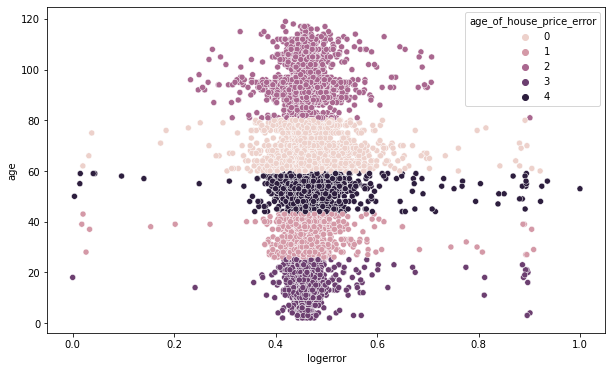

In [10]:
X= train[["age","logerror"]]
# def cluster_features(df, k):
kmeans = KMeans(n_clusters =5, random_state=347)

#group1 = train_scaled[['age','price_bath','taxvaluedollarcnt_zone','taxvaluedollarcnt', 'bathroomcnt', 'calculatedfinishedsquarefeet','price_sqft']]
kmeans.fit(X)
kmeans.predict(X)
train_scaled['age_of_house_price_error'] = kmeans.predict(X)
plt.figure(figsize=(10, 6))
sns.scatterplot(x = 'logerror', y = 'age', data = train_scaled, hue = 'age_of_house_price_error')

### Takeaways
### 4. does the age of the house matter when it comes to the price? 

#### - it appears that houses between 50 and 80 years old  have a high posibility of being mis-priced
#### - it also seems like there are not many new homes being built in the past 20 years, unlike other age groups

----

### 5. does price per sqfoot have a relationship with logerror?


<AxesSubplot:xlabel='logerror', ylabel='price_sqft'>

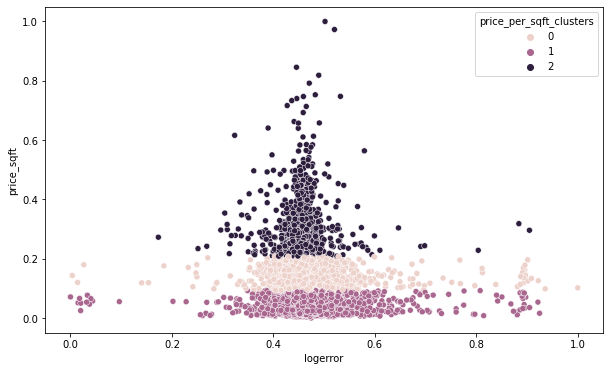

In [11]:
X= train[["price_sqft","logerror"]]
# def cluster_features(df, k):
kmeans = KMeans(n_clusters =3, random_state=347)
kmeans.fit(X)
kmeans.predict(X)
train_scaled['price_per_sqft_clusters'] = kmeans.predict(X)
plt.figure(figsize=(10, 6))
sns.scatterplot(x = 'logerror', y = 'price_sqft', data = train_scaled, hue = 'price_per_sqft_clusters')

# sns.scatterplot(x = 'logerror', y = 'price_sqft', data = train_scaled, hue = 'clustered_features')


## Takeaways
### 5. does price per sqfoot have a relationship with logerror?

#### -  houses with price per sq footage below 0.2 appear to be a big chunk of the logerror seems like the ML population of error is in the ordinary homes
#### -  isolating these properties and maybe creating a model just for them might be an option a model for these clusters 


---

### Correlation matrix

In [25]:
#getting the correlation matrix vs the logerror column
cor = train_scaled.corr()
cor

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,longitude,latitude,regionidzip,taxvaluedollarcnt,logerror,month,...,county_Orange,county_Ventura,price_sqft,age,price_bath,taxvaluedollarcnt_zone,price_per_bathroom_clusters,regional_prices_clusters,age_of_house_price_error,price_per_sqft_clusters
parcelid,1.000000,0.112419,0.125774,0.116632,-0.096597,-0.249312,0.364844,0.096046,0.012031,0.008209,...,0.338285,0.617790,0.018333,-0.248499,0.007986,0.167997,-0.124285,0.150403,0.214837,-0.134332
bathroomcnt,0.112419,1.000000,0.628937,0.830032,0.015554,-0.004991,0.211820,0.502915,0.025496,0.010774,...,0.154394,0.087379,-0.006295,-0.537151,-0.097369,0.366127,-0.116371,0.287995,0.247842,-0.104829
bedroomcnt,0.125774,0.628937,1.000000,0.637997,0.007061,0.010852,0.197812,0.276244,0.028785,0.009271,...,0.129620,0.103998,-0.128888,-0.378764,-0.101195,0.154523,-0.080922,0.138927,0.261176,-0.083519
calculatedfinishedsquarefeet,0.116632,0.830032,0.637997,1.000000,0.014746,-0.029039,0.179882,0.568965,0.029488,0.007844,...,0.152492,0.092037,-0.034281,-0.476440,0.067142,0.406619,-0.123227,0.310726,0.229054,-0.098801
longitude,-0.096597,0.015554,0.007061,0.014746,1.000000,-0.535140,0.195375,-0.000991,0.034387,-0.005635,...,0.601954,-0.684380,-0.029365,-0.113566,-0.029429,-0.000434,-0.044847,-0.055670,0.034751,-0.044041
latitude,-0.249312,-0.004991,0.010852,-0.029039,-0.535140,1.000000,0.099493,-0.191008,-0.034475,-0.008905,...,-0.665695,0.255661,-0.184409,-0.050105,-0.171987,-0.337248,0.142029,-0.194033,-0.074571,0.133852
regionidzip,0.364844,0.211820,0.197812,0.179882,0.195375,0.099493,1.000000,-0.006654,0.019698,-0.003440,...,0.497239,0.254676,-0.142690,-0.552332,-0.156532,-0.007081,-0.046240,-0.008553,0.226592,-0.053061
taxvaluedollarcnt,0.096046,0.502915,0.276244,0.568965,-0.000991,-0.191008,-0.006654,1.000000,-0.004769,0.013438,...,0.149140,0.045136,0.734361,-0.245647,0.732717,0.575543,-0.173593,0.424311,0.104259,-0.152405
logerror,0.012031,0.025496,0.028785,0.029488,0.034387,-0.034475,0.019698,-0.004769,1.000000,0.002432,...,0.037710,-0.013459,-0.031997,-0.015662,-0.030685,0.005696,-0.007514,0.006002,0.020251,-0.003657
month,0.008209,0.010774,0.009271,0.007844,-0.005635,-0.008905,-0.003440,0.013438,0.002432,1.000000,...,0.004720,0.005738,0.013603,-0.003440,0.010105,0.020002,-0.008173,0.020940,0.008254,-0.009508


## Takeaways
#### - After running a correlation matrix,  
#### - there were no significant corelation coefficients, with the logerror
#### - therefore more statistical tests are needed

---

## Hypothesis testing 

- In this section I will be checking the wheather the relationhip to log error is random 
- Afterwards, I will proceed to pick 2 of the best features to model with

### Price per sqfeet

$H 0 $: Price per squareft has no effect on the logerror

$H1$: Price per sqft affects the logerror

In [13]:
a = 0.05

In [14]:
# here I will use Pearsons r to check the correlation between the variables 
x = train_scaled.price_sqft
y = train_scaled.logerror

corr, p = stats.pearsonr(x, y)
print(f'corr = {corr:.5f}')
print(f'p = {p:.5f}')

if p<a:
    print(f"I reject the null hypothesis")
else:
    print(f"I failed to reject the null hypothesis")


corr = -0.03200
p = 0.00000
I reject the null hypothesis


---

###  Price per bathroom

$H 0 $: Price per bathroom has no effect o the logerror

$H1$: Price per bathroom has an effect on logerror 

In [15]:
# here I will use Pearsons r to check the correlation between the variables 
x = train_scaled.price_bath
y = train_scaled.logerror

corr, p = stats.pearsonr(x, y)
print(f'corr = {corr:.5f}')
print(f'p = {p:.5f}')

if p<a:
    print(f"I reject the null hypothesis")
else:
    print(f"I failed reject the null hypothesis")

corr = -0.03068
p = 0.00000
I reject the null hypothesis


---

### Price per region

$H 0 $: average price of the  region has no effect o the logerror

$H 1 $: average price of the  region has an effect on the logerror

In [16]:
# here I will use Pearsons r to check the correlation between the variables 
x = train_scaled.taxvaluedollarcnt_zone
y = train_scaled.logerror

corr, p = stats.pearsonr(x, y)
print(f'corr = {corr:.5f}')
print(f'p = {p:.5f}')

if p<a:
    print(f"I reject the null hypothesis")
else:
    print(f"I fail to reject the null hypothesis")

corr = 0.00570
p = 0.34568
I fail to reject the null hypothesis


### Takeaways 
- most of my features failed to reject the null hypothesis
- the average price per zipcode failed to reject the null hypothesis
- I suspect that negtive log might be running some interferance  

# Modeling
        - dropped the target variable to avoid data leakage
        - scaled the features that I used in modeling (train, validate and test)
        

In [17]:
#this code drops the target variable perparing the df for modeling
train_scaled_modeling = train_scaled.drop(columns = ["logerror"])
validate_scaled_modeling = validate_scaled.drop(columns = ["logerror"])
test_scaled_modeling = test_scaled.drop(columns = ["logerror"])

## Baseline (using mean and  median)

In [18]:
# the code bellow  preps the scaled data frames and splits them to scaled X and y train, X and y validate and X and y test
X_train, y_train = train_scaled_modeling, train_scaled["logerror"]
X_validate, y_validate = validate_scaled_modeling, validate_scaled.logerror
X_test, y_test = test_scaled_modeling, test_scaled.logerror
y_train = pd.DataFrame(train.logerror)
y_validate = pd.DataFrame(validate.logerror)
y_test = pd.DataFrame(test.logerror)


# 1. Predict zillow error 
y_train_mean = y_train['logerror'].mean()
y_train['y_train_mean'] = y_train_mean
y_validate['y_train_mean'] = y_train_mean

# 2. compute prices prediction
y_train_median = y_train['logerror'].median()
y_train['y_train_median'] = y_train_median
y_validate['y_train_median'] = y_train_median

# 3. RMSE for mean
rmse_train = mean_squared_error(y_train.logerror, y_train.y_train_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.y_train_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
            "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE for median
rmse_train = mean_squared_error(y_train.logerror, y_train.y_train_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.y_train_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
                  "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  0.17 
Validate/Out-of-Sample:  0.16
RMSE using Median
Train/In-Sample:  0.17 
Validate/Out-of-Sample:  0.16


### Takeaways
#### first assumption is that the baseline seems to be very close to 0, indicating a very small error which is challenging to beat

----

## Linear Regression Model (engineered features)

In [19]:

# create the model object
lm2 = LinearRegression(normalize=True)
X_trainlm2 = X_train[["price_sqft","price_bath"]]
X_validatelm2 = X_validate[["price_sqft","price_bath"]]
#X_testlm = X_testlm[["monthly_logerror","bathroomcount_clusters","taxvaluedollarcnt_zone"]]
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_trainlm2, y_train.logerror)

# predict train
y_train['logerror_pred2'] = lm2.predict(X_trainlm2)

# evaluate: rmse
rmse_train_lr1 = mean_squared_error(y_train.logerror, y_train.logerror_pred2)**(1/2)

# predict validate
y_validate['logerror_pred2'] = lm2.predict(X_validatelm2)

# evaluate: rmse
rmse_validate_lr1 = mean_squared_error(y_validate.logerror, y_validate.logerror_pred2)**(1/2)

# # testing on the best model
# y_test['logerror_pred'] = lm.predict(X_testlm)

# # evaluate: rmse
# rmse_test_lr = mean_squared_error(y_test.total_taxes_assessed, y_test.total_taxes_pred)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train_lr1, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lr1) #, "RMSE for OLS using LinearRegression\ntest/In-Sample: ")#,rmse_test_lr)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.16781087278657186 
Validation/Out-of-Sample:  0.16191723043385817


### Takeaways

#### 1.  here is an OLS model with engineered features
        - "price_sqft" - price per square feet
        - "price_bath" - price per bathroom
        - "taxvaluedollarcnt_zone" - average prices per zipcode
#### 2.  the model is almost at par with baseline beating baseline by (0.000 insignificant)
#### 3.  most likely I will go back to the drawing board and engineer more features, after the web scrapping class soon

---

## Linear regression Model (different features)


In [20]:
# create the model object
lm3 = LinearRegression(normalize=True)
X_train_tr = X_train[["bedroomcnt","bathroomcnt","calculatedfinishedsquarefeet"]]
X_validate_tr = X_validate[["bedroomcnt","bathroomcnt","calculatedfinishedsquarefeet"]]

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm3.fit(X_train_tr, y_train.logerror)

# predict train
y_train['logerror_predtr'] = lm3.predict(X_train_tr)

# evaluate: rmse
rmse_train_tr = mean_squared_error(y_train.logerror, y_train.logerror_predtr)**(1/2)

# predict validate
y_validate['logerror_predtrv'] = lm3.predict(X_validate_tr)

# evaluate: rmse
rmse_validate_tr = mean_squared_error(y_validate.logerror, y_validate.logerror_predtrv)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train_tr, 
      "\nValidation/Out-of-Sample: ", rmse_validate_tr)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  0.16781123629032207 
Validation/Out-of-Sample:  0.16183850561530422


## Takeaways
#### still no change vs the baseline 


---

# LassoLars model

In [21]:
# create the model
lars = LassoLars(alpha=1.0)
X_train_ls = X_train[["price_sqft","price_bath"]]
X_validate_ls = X_validate[["price_sqft","price_bath"]]
# fit the model
lars.fit(X_train_ls, y_train.logerror)

# predict train
y_train['logerror_predls'] = lars.predict(X_train_ls)

# evaluate: rmse
rmse_trainls = mean_squared_error(y_train.logerror, y_train.logerror_predls)**(1/2)

# predict validate
y_validate['logerror_predls'] = lars.predict(X_validate_ls)

# evaluate: rmse
rmse_validatels = mean_squared_error(y_validate.logerror, y_validate.logerror_predls)**(1/2)

print("RMSE for LassoLars\nTraining/In-Sample: ", rmse_trainls, 
      "\nValidation/Out-of-Sample: ", rmse_validatels)

RMSE for LassoLars
Training/In-Sample:  0.16789845530414557 
Validation/Out-of-Sample:  0.1620271048667998


## Takeaways
- The lasso lars model also yielded results similar to the baseline
- Then next I proceeded to model per region

---

## Linear Regression Model LA county

In [22]:
#this code converts data from la county to a split and scaled dataframe with the target variable dropped(ready to be used for modeling )

la_df_train = train_scaled.mask(df.county_Los_Angeles == False).dropna()
la_df_validate = validate_scaled.mask(df.county_Los_Angeles == False).dropna()
la_df_test = test_scaled.mask(df.county_Los_Angeles == False).dropna()
la_df_test  = la_df_test.dropna()
X_train_la1, y_train_la1 = la_df_train.drop(columns = ["logerror"]), la_df_train["logerror"]
X_validate_la1, y_validate_la1 = la_df_validate.drop(columns = ["logerror"]), la_df_validate.logerror
X_test_la1, y_test_la1 = la_df_test.drop(columns = ["logerror"]), la_df_test.logerror
y_train_la1 = pd.DataFrame(la_df_train.logerror)
y_validate_la1 = pd.DataFrame(la_df_validate.logerror)
y_test_la1 = pd.DataFrame(la_df_test.logerror)


In [23]:
# create the model object
lm = LinearRegression(normalize=True)
X_train_la1 = X_train_la1[["price_sqft","price_bath"]]
X_validate_la1 = X_validate_la1[["price_sqft","price_bath"]]
X_test_la1 = X_test_la1[["price_sqft","price_bath"]]
# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train_la1, y_train_la1.logerror)

# predict train
y_train_la1['logerror_pred3'] = lm.predict(X_train_la1)

# evaluate: rmse
rmse_train_lr = mean_squared_error(y_train_la1.logerror, y_train_la1.logerror_pred3)**(1/2)

# predict validate
y_validate_la1['logerror_pred3'] = lm.predict(X_validate_la1)

# evaluate: rmse
rmse_validate_lr = mean_squared_error(y_validate_la1.logerror, y_validate_la1.logerror_pred3)**(1/2)

# testing on the best model
y_test_la1['logerror_pred3'] = lm.predict(X_test_la1)

# evaluate: rmse
rmse_test_lr = mean_squared_error(y_test_la1.logerror, y_test_la1.logerror_pred3)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train_lr, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lr, "RMSE for OLS using LinearRegression\ntest/In-Sample: ",rmse_test_lr)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.028516089859069987 
Validation/Out-of-Sample:  0.029760557055013265 RMSE for OLS using LinearRegression
test/In-Sample:  0.030347912003006468


### Takeaways
#### 1.  the OLS model fitted for LA county beats the baseline, which confirms one of my hypothesis that house prices are determined by the region/ location. 
#### 2.  the ML models should be split per county or region in order to get better results
#### 3. to conclude, I ran it with the test  which was also at 0.03 and base line at 0.16

---

## Summary
    - the OLS model shows the most promise with these two features.
    - most of the models I tried were close but did none beat the baseline
    - however when broken down into regions (LA county) the model seem to beat the baseline 
    
## Baseline

- RMSE using Mean

- Train/In-Sample:  0.17

- Validate/Out-of-Sample:  0.16

- RMSE using Median

- Train/In-Sample:  0.17

- Validate/Out-of-Sample: 0.16


## Linear regression model

-  RMSE for OLS using LinearRegression
-  Training/In-Sample:  0.028515926017686637 
-  Validation/Out-of-Sample:  0.029760172770734873 
-  RMSE for OLS using LinearRegression
-  test/In-Sample:  0.030345106614845723






In [24]:
RMSE_baseline_train = rmse_train 
RMSE_baseline_validate = rmse_validate
RMSE_train_lr = rmse_train_lr
RMSE_validate_lr = rmse_validate_lr
print (f"Difference with Baseline Train = {RMSE_baseline_train-RMSE_train_lr}")
print(f"Difference with Baseline Validate = {RMSE_baseline_validate-RMSE_validate_lr}")

Difference with Baseline Train = 0.139792402001799
Difference with Baseline Validate = 0.13257241036660694


---

### Conclusion

#### 1. It appears that price per sqfootage and price per bedroom might be a strong driver of the logerror

#### 2. The models landed very close to the baseline. 

#### 3.  However, after further further domain investigation it seems like there are extra features about the home buyer that are needed in order to factor in the demand in the model. These are:

    - mortgage interest rates
    - median household income 
    

#### 4. With more time, I would like to investigate more on the housng summer demand because of the chart divergence between price prediction and log error. This could be a factor that influences the log error 

#### 5. According to the clustering, majority of the mispriced houses  were in the 150k - 500k price range-  with more time I would explore those clusters and model a regression on the price deltas.

#### From the zillow data and ML model a question arose:
#### **** how much of the predictions are accurate or is it just a self fulfilling prophecy (scenario) where people buy homes based on the zillow zestimates rather than zillow accurately predicting the prices.  (because  there arent many competitors to zestimates) in 2017 